## yelpReviewsTopicModelling

In [1]:
## IMPORT NECESSARY PACKAGES #1

from pprint import pprint
# import pandasql as ps
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from zipfile import ZipFile
from io import BytesIO
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
# InteractiveShell.ast_node_interactivity = "all"
# CSS = """
# .output {
#     flex-direction: row;
# }
# """
# HTML('<style>{}</style>'.format(CSS))

sns.set()

In [2]:
## LOAD TORONTO DATASETS & DELETE WEIRD 

restaurants_df = pd.read_csv("datasets/american_restaurants.csv", sep='\t', encoding='utf-8')
reviews_df = pd.read_csv("datasets/review_sentiment.csv", encoding='utf-8')

del(restaurants_df['Unnamed: 0'])
# del(reviews_df['Unnamed: 0'])

restaurants_df = restaurants_df[restaurants_df['RestaurantsPriceRange2'] == 2]
reviews_df = reviews_df.loc[reviews_df['business_id'].isin(restaurants_df.business_id)]

In [3]:
restaurants_df.head()

,address,attributes,AcceptsInsurance,AgesAllowed,Alcohol,Ambience,BYOB,BYOBCorkage,BestNights,BikeParking,...,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,cuisine
0,2201 S Fort Apache Rd,NaN,NaN,NaN,full_bar,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,1,36.147496,-115.298066,Chicago Brewing Company,Westside,89117.0,446,3.5,NV,american
4,"7160 North Durango Dr, Ste 110",NaN,NaN,NaN,beer_and_wine,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,0,36.291436,-115.287016,Table 89,Centennial,89149.0,79,3.5,NV,american
5,6689 Las Vegas Blvd,NaN,NaN,NaN,beer_and_wine,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,1,36.067581,-115.174230,LV bar,Southeast,89119.0,22,4.5,NV,american
6,6683 Las Vegas Blvd S,NaN,NaN,NaN,full_bar,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,"{'monday': True, 'tuesday': False, 'friday': T...",True,...,1,36.066182,-115.175288,Miller's Ale House - Las Vegas,Southeast,89119.0,583,3.5,NV,american
7,"6430 N Durango Dr, Ste 110",NaN,NaN,NaN,full_bar,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,"{'monday': False, 'tuesday': False, 'friday': ...",True,...,1,36.277783,-115.286333,Distill - A Local Bar,Centennial,89149.0,203,4.0,NV,american


In [4]:
reviews_df.head()

,business_id,text,label,stars
0,jtQARsP6P-LbkyjbO1qNGg,Terrible. Dry corn bread. Rib tips were all fa...,-1,1.0
2,faPVqws-x-5k2CQKDNtHxw,People please...the only good thing about this...,1,1.0
5,3kdSl5mo9dWC4clrQjEDGg,????????????????????????????????????\r\n?????7...,0,4.0
6,f4x1YBxkLrZg652xt2KR5g,????????????????????\r\n???Link Hotel???????\r...,0,3.0
8,wuQDMDlqM17jQNo0lYQZ7g,One of the best experiences I have had in Vega...,1,5.0


In [5]:
print('Number of categories listed',restaurants_df['city'].nunique())

restaurants_df['city'].head()

Number of categories listed 1


0    Las Vegas
4    Las Vegas
5    Las Vegas
6    Las Vegas
7    Las Vegas
Name: city, dtype: object

In [6]:
len(restaurants_df)

774

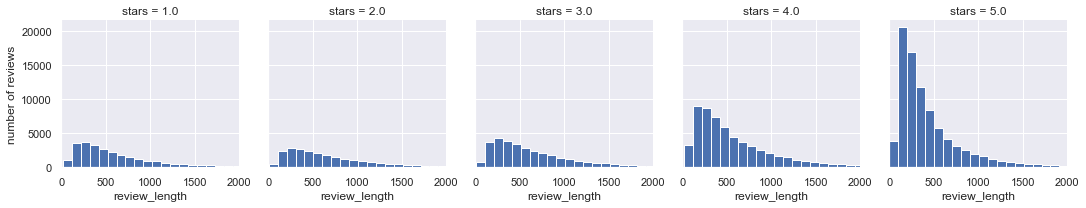

In [7]:
# check how the review lengths are distributed
reviews_df['review_length'] = reviews_df.text.map(len)

ax = sns.FacetGrid(data=reviews_df, col='stars', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)

ax.axes[0][0].set(ylabel='number of reviews');

In [8]:
pos_reviews = reviews_df.text[reviews_df.label == 1].values
neg_reviews = reviews_df.text[reviews_df.label == -1].values
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  182,678
Negative Reviews:  28,209


In [9]:
# additional stopwords
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'toronto', 'just', 
               'don', 'really', 'said', 'told', 'ok',
               'came', 'went', 'did', 'didn', 'good']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [10]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 20000
random_neg = np.random.choice(neg_reviews, size=num_reviews)
random_pos = np.random.choice(pos_reviews, size=num_reviews)

dicty = {'pizzas':'pizza', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_neg = [replace_words(w, dicty) for w in random_neg]
random_pos = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(random_neg)
pos_vectors = tfidf_pos.fit_transform(random_pos)

Wall time: 2.42 s


In [11]:
# Store TFIDF vectors in a Pandas DataFrame to investigate further
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
pos_df = pd.DataFrame(pos_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each column (word): highest means are most important words
col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()

In [12]:
no_top_words = 10

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 10 words in POSITIVE reviews:[('great',), ('place',), ('burger',), ('service',), ('order',), ('time',), ('vegas',), ('chicken',), ('amazing',), ('breakfast',)]
Top 10 words in NEGATIVE reviews:[('service',), ('order',), ('place',), ('burger',), ('time',), ('minutes',), ('bad',), ('horrible',), ('table',), ('server',)]


In [13]:
# delete dataframes to save memory
del neg_df
del pos_df

In [15]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [16]:
# create LSA model
num_topics = 7
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

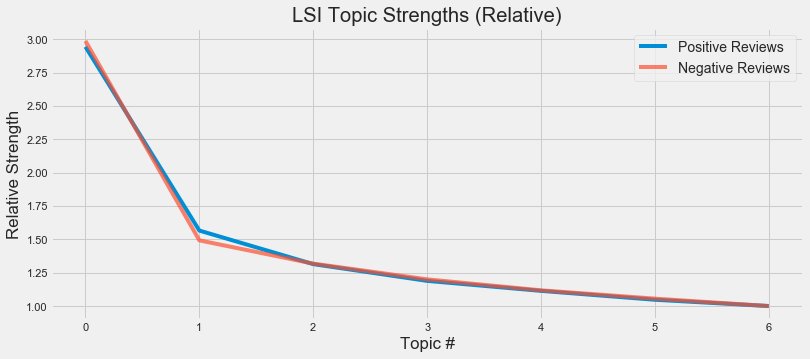

In [17]:
# elbow plot
singular_values_pos = lsi_pos.projection.s.tolist()
singular_values_pos_rel = [sv/singular_values_pos[-1] for sv in singular_values_pos]
singular_values_neg = lsi_neg.projection.s.tolist()
singular_values_neg_rel = [sv/singular_values_neg[-1] for sv in singular_values_neg]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_pos)), singular_values_pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(singular_values_neg)), singular_values_neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_pos)), range(len(singular_values_pos)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [18]:
topics_to_print = 5

In [19]:
# look at top positive topics
print('Top %d topics for POSITIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_pos.show_topics()[0:topics_to_print])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0,
  '0.251*"great" + 0.226*"burger" + 0.215*"place" + 0.184*"service" + '
  '0.159*"order" + 0.142*"time" + 0.129*"chicken" + 0.127*"vegas" + '
  '0.121*"breakfast" + 0.116*"amazing"'),
 (1,
  '0.788*"burger" + 0.293*"fries" + -0.200*"great" + -0.182*"breakfast" + '
  '-0.118*"service" + -0.102*"place" + 0.089*"truffle" + 0.087*"shake" + '
  '0.074*"cheese" + -0.072*"chicken"'),
 (2,
  '-0.579*"great" + 0.259*"chicken" + -0.217*"burger" + -0.212*"service" + '
  '0.206*"order" + -0.136*"awesome" + -0.133*"amazing" + -0.130*"place" + '
  '0.127*"fried" + -0.126*"atmosphere"'),
 (3,
  '0.485*"breakfast" + -0.235*"bar" + 0.212*"pancakes" + 0.189*"eggs" + '
  '-0.175*"hour" + -0.169*"happy" + -0.160*"drinks" + 0.158*"burger" + '
  '0.134*"chicken" + -0.132*"beer"'),
 (4,
  '-0.587*"chicken" + 0.348*"breakfast" + -0.291*"great" + -0.235*"fried" + '
  '-0.197*"waffles" + 0.153*"place" + 0.148*"pancakes" + -0.135*"salad" + 

In [20]:

# look at top negative topics
print('Top %d topics for NEGATIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_neg.show_topics()[0:topics_to_print])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0,
  '0.241*"order" + 0.236*"service" + 0.193*"place" + 0.171*"minutes" + '
  '0.161*"time" + 0.154*"burger" + 0.123*"bad" + 0.123*"table" + 0.119*"took" '
  '+ 0.117*"server"'),
 (1,
  '-0.653*"burger" + -0.255*"fries" + 0.222*"minutes" + 0.171*"service" + '
  '0.127*"table" + -0.126*"cheese" + 0.124*"waited" + -0.117*"chicken" + '
  '0.094*"server" + 0.083*"manager"'),
 (2,
  '0.533*"burger" + 0.282*"minutes" + -0.208*"buffet" + -0.207*"chicken" + '
  '-0.172*"place" + -0.170*"breakfast" + 0.156*"order" + 0.155*"fries" + '
  '0.155*"waited" + 0.114*"table"'),
 (3,
  '0.426*"service" + -0.367*"order" + -0.310*"chicken" + 0.248*"horrible" + '
  '0.223*"burger" + 0.214*"place" + -0.128*"salad" + 0.126*"bad" + '
  '0.124*"terrible" + 0.119*"rude"'),
 (4,
  '-0.457*"service" + -0.312*"horrible" + -0.248*"chicken" + 0.206*"bar" + '
  '-0.196*"terrible" + 0.175*"place" + -0.170*"order" + -0.137*"cold" + '
  '0.132*"people

In [21]:

%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 4.13 s


In [22]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.093*order, 0.866*time, 0.693*bar, 0.641*pretty, 0.613*table, 0.595*restaurant
Topic 1:   3.138*burger, 1.175*fries, 0.353*truffle, 0.345*shake, 0.319*cheese, 0.280*onion
Topic 2:   2.827*great, 1.220*service, 0.492*atmosphere, 0.401*awesome, 0.341*excellent, 0.282*friendly
Topic 3:   2.120*breakfast, 0.891*pancakes, 0.797*eggs, 0.492*toast, 0.446*coffee, 0.432*hash
Topic 4:   2.266*chicken, 0.994*fried, 0.854*waffles, 0.442*salad, 0.317*cheese, 0.301*delicious
Topic 5:   1.757*place, 1.338*love, 1.212*amazing, 0.770*vegas, 0.597*best, 0.542*staff

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.958*place, 0.958*bar, 0.648*people, 0.539*time, 0.538*bartender, 0.537*rude
Topic 1:   3.092*burger, 1.065*fries, 0.334*cheese, 0.285*shake, 0.214*medium, 0.183*order
Topic 2:   1.631*minutes, 1.432*order, 1.000*table, 0.866*waited, 0.842*took, 0.789*server
To

In [23]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])


3553
Fantastic food, great price, great atmosphere, great service, HUGE portions of delicious hashes, benedicts, sandwiches and other treats. Biscuits with FRESH jam are unreal. The banana brown sugar flapjack was delicious. It was enormous and had a crispy crust of melted sugar on it like a crême bruleé with large slices of ripe banana in the batter...it was 15" across! Corned beef hash was incredible. Even the coffee was excellent. High recommendation - I do not give 4 stars lightly.


In [24]:
# look at a random negative review
review_num = np.random.randint(0, high=len(random_neg))
print(review_num)
print(random_neg[review_num])


5183
Place is nice, people are nice but the food sucks balls .. no flavor whatsoever. Ordered the spinach dip and it taste so bad, the chicken fingers my sons order were hard to bite and stringy (double yuck) I would go just for the experience of those alcohol drinks. My husband order a bubbling drink and it taste like big o fountain soda but that was it. I wouldn't go back for the food that's for sure.  Oh their super fast to bring out the food like VERY fast.  We were shocked maybe that's why the food tasted so bad .. stale French fries found at Sugar factory


In [25]:

# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [26]:

# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
Great little joint. For a holiday weekend and only having one server for the entire restaurant she did a great job. Poor management for only scheduling only 1 until 830.
--------------------------------------------------
>> Similarity 1.000
We had a great time here. We had a Groupon for $12 for $24. I've heard about the drinks here and was skeptical but they did not disappoint. John and Scott were GREAT help. John was very attentive to our needs and helped us decide on the Mai Tai goblet!! Yummy!! Definitely will dine here again.
--------------------------------------------------
>> Similarity 1.000
Adorable !!!! Super eclectic inside. Great patio seating. Must see the patio in the back.
--------------------------------------------------


In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(neg_reviews, size=num_reviews)
cv_random_pos = np.random.choice(pos_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [28]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [29]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=5, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=5, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

Wall time: 1min 52s


In [30]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
pprint(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
pprint(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0,
  '0.010*"great" + 0.009*"order" + 0.007*"delicious" + 0.007*"place" + '
  '0.006*"menu" + 0.006*"sauce" + 0.006*"chicken"'),
 (1,
  '0.015*"service" + 0.013*"great" + 0.012*"order" + 0.009*"place" + '
  '0.008*"chicken" + 0.008*"time" + 0.007*"vegas"'),
 (2,
  '0.017*"place" + 0.017*"breakfast" + 0.013*"great" + 0.010*"order" + '
  '0.009*"service" + 0.009*"wait" + 0.009*"time"'),
 (3,
  '0.021*"great" + 0.019*"place" + 0.013*"service" + 0.010*"bar" + '
  '0.010*"time" + 0.008*"drinks" + 0.007*"nice"'),
 (4,
  '0.047*"burger" + 0.021*"fries" + 0.013*"order" + 0.010*"place" + '
  '0.009*"cheese" + 0.008*"great" + 0.007*"time"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0,
  '0.020*"service" + 0.012*"minutes" + 0.011*"time" + 0.011*"manager" + '
  '0.010*"server" + 0.010*"order" + 0.010*"asked"'),
 (1,
  '0.019*"place" + 0.017*"service" + 0.009*"bad" + 0.008*"or

## Continuing with NMF

In [31]:
# let's remind ourselves of the POSITIVE topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.093*order, 0.866*time, 0.693*bar, 0.641*pretty, 0.613*table, 0.595*restaurant
Topic 1:   3.138*burger, 1.175*fries, 0.353*truffle, 0.345*shake, 0.319*cheese, 0.280*onion
Topic 2:   2.827*great, 1.220*service, 0.492*atmosphere, 0.401*awesome, 0.341*excellent, 0.282*friendly
Topic 3:   2.120*breakfast, 0.891*pancakes, 0.797*eggs, 0.492*toast, 0.446*coffee, 0.432*hash
Topic 4:   2.266*chicken, 0.994*fried, 0.854*waffles, 0.442*salad, 0.317*cheese, 0.301*delicious
Topic 5:   1.757*place, 1.338*love, 1.212*amazing, 0.770*vegas, 0.597*best, 0.542*staff


In [32]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #254
-------------------------
Big portion plates!
Great food!
The lounge is relaxing and their alcoholic drinks are good!
I always have to make a stop here when I'm in Vegas
-------------------------
Topic 2: 0.0348
Topic 0: 0.0118
Topic 5: 0.0113
Topic 4: 0.0026
Topic 3: 0.0019
Topic 1: 0.0000


In [33]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.958*place, 0.958*bar, 0.648*people, 0.539*time, 0.538*bartender, 0.537*rude
Topic 1:   3.092*burger, 1.065*fries, 0.334*cheese, 0.285*shake, 0.214*medium, 0.183*order
Topic 2:   1.631*minutes, 1.432*order, 1.000*table, 0.866*waited, 0.842*took, 0.789*server
Topic 3:   2.446*service, 1.305*horrible, 0.867*terrible, 0.638*bad, 0.604*slow, 0.527*customer
Topic 4:   1.923*chicken, 0.849*order, 0.826*salad, 0.581*sandwich, 0.517*cheese, 0.505*fried
Topic 5:   1.226*breakfast, 1.189*buffet, 0.742*eggs, 0.510*price, 0.443*vegas, 0.393*quality


In [34]:
# now investigate a random negative review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #14937
-------------------------
The most impressive thing about this restaurant is the decor. Beautifully decorated, swanky bar, eye catching touches everywhere but unfortunately, that's where it ends. Everything is else is lackluster. 

The service isn't good. They all look like they'd rather be somewhere else. Our busser was more attentive than our waiter. He never delivered the dishes or checked on our food but he popped up every 30 seconds to pick up the signed check. For these price you would think they would bring it with either service or food but the food was pretty average too. It reminds me of a high end cafe. I had a three course meal and there isn't one thing that stood out. The beet salad was blah and our apple crostata came with no ice cream and was so thick all you tasted was dough. When you're not delicate or rush pastry, it shows. I think the most disappointing part of our meal was having to eat around cigarette smokers on nearby tables (using the rest

## Topic Modeling All Reviews 
At this point, we can see that our topics are relatively interpretable and match along with the reviews they're trying to categorize. Let's proceed with topic modeling all reviews and businesses using NMF.

In [35]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  182,678
Negative Reviews:  28,209


In [36]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words with defined dictionary 'dicty'
pos_reviews = [replace_words(w, dicty) for w in pos_reviews]
neg_reviews = [replace_words(w, dicty) for w in neg_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

Wall time: 13.3 s


In [37]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 13.1 s


In [38]:
no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   2.003*order, 1.439*time, 1.125*bar, 1.089*pretty, 1.039*table, 0.994*restaurant
Topic 1:   5.383*burger, 2.012*fries, 0.622*shake, 0.592*cheese, 0.583*truffle, 0.463*onion
Topic 2:   4.819*great, 2.052*service, 0.730*atmosphere, 0.579*excellent, 0.571*awesome, 0.424*price
Topic 3:   3.577*breakfast, 1.454*pancakes, 1.385*eggs, 0.864*toast, 0.740*coffee, 0.732*hash
Topic 4:   3.777*chicken, 1.638*fried, 1.417*waffles, 0.691*salad, 0.625*cheese, 0.559*sandwich
Topic 5:   2.922*place, 1.898*love, 1.844*amazing, 1.397*vegas, 1.186*staff, 1.186*best

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   1.950*place, 1.101*bar, 0.737*time, 0.715*people, 0.589*bartender, 0.573*night
Topic 1:   3.235*burger, 1.186*fries, 0.382*cheese, 0.349*shake, 0.219*medium, 0.194*shack
Topic 2:   1.808*minutes, 1.617*order, 1.037*table, 0.943*took, 0.916*waited, 0.867*server
Topic 3:   1.930*chicken, 0.8

In [39]:
# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'order/time', 1:'burger/fries', 2:'service/atmosphere', 
              3:'breakfast/pancakes', 4:'chicken/waffles', 5:'location/atmosphere'}

neg_topics = {0:'location/bar', 1:'burger/fries', 2:'waiting_time', 
              3:'chicken/salad', 4:'bad_service', 5:'breakfast/price'}

## Adding Topic Weights to Pandas DataFrame

In [40]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = reviews_df[['business_id', 'stars', 'text', 'review_length']][reviews_df.stars>3].reset_index()
df_neg = reviews_df[['business_id', 'stars', 'text', 'review_length']][reviews_df.stars<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

In [41]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.00733115 0.         0.         0.         0.00096004 0.01346228]
Sum of weights:  0.021753477216583453


In [42]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.33701062 0.         0.         0.         0.04413286 0.61885652]]
Sum of normalized weights:  1.0


In [43]:
# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [44]:
# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,jtQARsP6P-LbkyjbO1qNGg,1.0,Terrible. Dry corn bread. Rib tips were all fa...,156,0.000802,0.058268,0.000000,0.611918,0.195864,0.133147
1,faPVqws-x-5k2CQKDNtHxw,1.0,People please...the only good thing about this...,622,0.376794,0.041870,0.199076,0.337674,0.000000,0.044587
2,ZtsnwjxjzMUI6tDZNrJUeA,1.0,If there was an option to give this place nega...,734,0.610305,0.000000,0.271824,0.007311,0.110560,0.000000
3,NvKNe9DnQavC9GstglcBJQ,1.0,My friends and I went into Grand Lux Cafe at t...,580,0.033947,0.246751,0.501850,0.000000,0.217452,0.000000
4,jdAdf7keZac1idbgNKG2pw,1.0,Went with my daughter tonight and was refused ...,500,0.233010,0.724579,0.000000,0.000000,0.000000,0.042411


In [45]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [46]:
df_pos_bsns.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,-CQokjildrY7UZezXCdEBw,4.875000,40,743.800000,0.228314,0.097026,0.197794,0.149700,0.094563,0.232603
1,-JfncbVURtvuzBbof40o1w,4.176471,34,556.735294,0.381605,0.087654,0.158816,0.089324,0.067062,0.215538
2,-OEIW0dO96-492qa_luxaw,4.557143,210,669.052381,0.258139,0.081709,0.178006,0.134155,0.129887,0.218103
3,-PGsEXB6DFTVKa1eDOlzWA,4.660550,109,459.532110,0.251629,0.101541,0.212126,0.118247,0.096253,0.220204
4,-SGZcGqnsp_uRIjKP2RGZg,4.666667,6,343.666667,0.213280,0.016076,0.433839,0.139536,0.032799,0.164471


In [47]:
df_neg_bsns.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,-CQokjildrY7UZezXCdEBw,2.000000,1,1657.000000,0.444163,0.000000,0.191896,0.130308,0.233632,0.000000
1,-JfncbVURtvuzBbof40o1w,1.430769,65,642.630769,0.248158,0.142531,0.177165,0.159990,0.153210,0.118944
2,-OEIW0dO96-492qa_luxaw,1.363636,33,841.121212,0.200100,0.137036,0.197750,0.163034,0.135724,0.166354
3,-PGsEXB6DFTVKa1eDOlzWA,1.400000,65,940.276923,0.198195,0.121829,0.195939,0.167739,0.189003,0.127294
4,-SGZcGqnsp_uRIjKP2RGZg,1.000000,3,632.000000,0.820040,0.022365,0.000000,0.011353,0.000000,0.146242


## Adding in Business Information 

In [48]:
# merge business name/city with topic data
df_pos_tot = df_pos_bsns.merge(restaurants_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars_y', 0, 1, 2, 3, 4, 5]]

df_neg_tot = df_neg_bsns.merge(restaurants_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars_y', 0, 1, 2, 3, 4, 5]]

In [49]:
# peek into business/topic distributions
df_neg_tot.head(10)

,business_id,name,city,stars_y,0,1,2,3,4,5
0,-CQokjildrY7UZezXCdEBw,Toddy Shop,Las Vegas,5.0,0.444163,0.000000,0.191896,0.130308,0.233632,0.000000
1,-JfncbVURtvuzBbof40o1w,The Cafe at Monte Carlo,Las Vegas,2.5,0.248158,0.142531,0.177165,0.159990,0.153210,0.118944
2,-OEIW0dO96-492qa_luxaw,Aces & Ales,Las Vegas,4.0,0.200100,0.137036,0.197750,0.163034,0.135724,0.166354
3,-PGsEXB6DFTVKa1eDOlzWA,Black Bear Diner,Las Vegas,3.5,0.198195,0.121829,0.195939,0.167739,0.189003,0.127294
4,-SGZcGqnsp_uRIjKP2RGZg,Ranch House Grille,Las Vegas,3.5,0.820040,0.022365,0.000000,0.011353,0.000000,0.146242
5,-U7tvCtaraTQ9b0zBhpBMA,MGM Grand Buffet,Las Vegas,2.5,0.258160,0.100571,0.173129,0.154207,0.186405,0.127528
6,-UtYWvCnUppcSaC_u1pTYQ,Kopper Keg Restaurant & Lounge,Las Vegas,4.0,0.375177,0.024044,0.000000,0.000000,0.495859,0.104919
7,-Ylpy3VyRWwubf9dysuwjQ,The Cheesecake Factory,Las Vegas,3.5,0.243450,0.107310,0.159245,0.112695,0.162365,0.214936
8,-a857YYdjzgOdOjFFRsRXQ,Beer Park,Las Vegas,3.5,0.265302,0.068033,0.172120,0.178308,0.149068,0.167170
9,-kbPPBNsIPDfMfgUGO7QhA,Kopper Keg South,Las Vegas,4.0,0.340478,0.019509,0.286910,0.102709,0.179072,0.071321


In [52]:
scores = df_neg_bsns[df_neg_bsns.business_id == '-PGsEXB6DFTVKa1eDOlzWA'].iloc[:,-6:].values
print(restaurants_df[restaurants_df.business_id == '-PGsEXB6DFTVKa1eDOlzWA']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in neg_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, neg_topics[n], scores[0][n]))

Black Bear Diner - Positive Reviews
------------------------------------
Topic 0: location/bar       > 0.1982
Topic 1: burger/fries       > 0.1218
Topic 2: waiting_time       > 0.1959
Topic 3: chicken/salad      > 0.1677
Topic 4: bad_service        > 0.1890
Topic 5: breakfast/price    > 0.1273


In [51]:
%%time
# write to CSV
df_pos_tot.to_csv('datasets/pos_bsns.csv')
df_neg_tot.to_csv('datasets/neg_bsns.csv')
df_pos.to_csv('datasets/pos_reviews.csv')
df_neg.to_csv('datasets/neg_reviews.csv')

Wall time: 5.99 s
